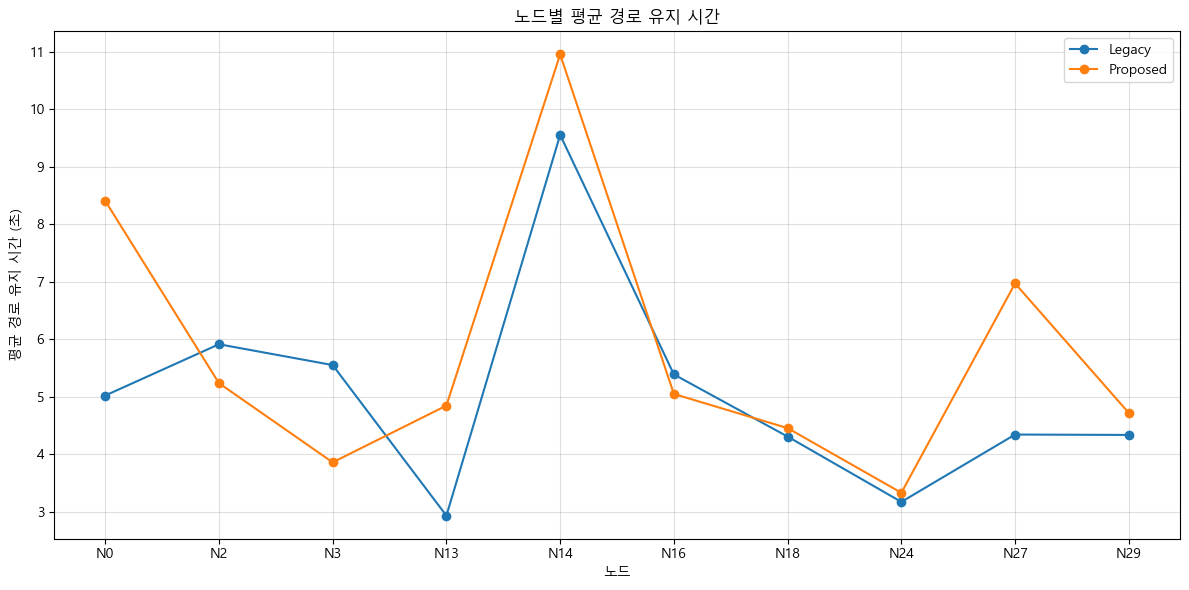

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]
methods = ['L', 'P']
output_dir = os.path.join(base_path, "analysis_results")
os.makedirs(output_dir, exist_ok=True)

results = {
    'node': [],
    'method': [],
    'avg_duration': [],
    'route_count': []
}
all_durations = {'Legacy': [], 'Proposed': []}

def load_rerr_times(filepath):
    rerr_times = {}
    if not os.path.exists(filepath):
        return rerr_times
    with open(filepath, 'r') as f:
        current_time = None
        for line in f:
            time_match = re.search(r'\[RERR 생성\] 시간: ([\d.]+)', line)
            if time_match:
                current_time = float(time_match.group(1))
                continue
            dst_match = re.search(r'- 대상: ([\d.]+\.[\d.]+\.[\d.]+\.[\d.]+)', line)
            if dst_match and current_time is not None:
                dst = dst_match.group(1)
                if dst not in rerr_times:
                    rerr_times[dst] = []
                rerr_times[dst].append(current_time)
    return rerr_times

def compute_route_durations(df, rerr_times):
    df = df.sort_values(by='Time')
    durations = []
    route_dict = {}

    for _, row in df.iterrows():
        dst = row['Destination']
        time = row['Time']
        new_lt = row['New_LifeTime']
        old_lt = row['Previous_LifeTime']
        if pd.isna(new_lt) or pd.isna(old_lt):
            continue

        if new_lt > old_lt:
            if dst not in route_dict or time > route_dict[dst]['end']:
                route_dict[dst] = {'start': time, 'end': new_lt}
            else:
                route_dict[dst]['end'] = max(route_dict[dst]['end'], new_lt)

        elif new_lt < old_lt:
            if dst in route_dict and new_lt <= route_dict[dst]['end']:
                durations.append(route_dict[dst]['end'] - route_dict[dst]['start'])
                del route_dict[dst]

        if dst in rerr_times and dst in route_dict:
            for rerr_time in rerr_times[dst]:
                if route_dict[dst]['start'] < rerr_time < route_dict[dst]['end']:
                    durations.append(rerr_time - route_dict[dst]['start'])
                    del route_dict[dst]
                    break

    for info in route_dict.values():
        durations.append(info['end'] - info['start'])

    return durations

for method in methods:
    for node in nodes:
        log_path = os.path.join(base_path, method, density, speed, node, 'aodv_routing_log.csv')
        rerr_path = os.path.join(base_path, method, density, speed, node, 'rerr_debug.txt')
        if not os.path.isfile(log_path):
            continue

        df = pd.read_csv(log_path)
        rerr_times = load_rerr_times(rerr_path)
        durations = compute_route_durations(df, rerr_times)
        avg_dur = sum(durations) / len(durations) if durations else 0

        results['node'].append(node)
        results['method'].append('Legacy' if method == 'L' else 'Proposed')
        results['avg_duration'].append(avg_dur)
        results['route_count'].append(len(durations))

        label = 'Legacy' if method == 'L' else 'Proposed'
        all_durations[label].extend(durations)

df_result = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
for method in ['Legacy', 'Proposed']:
    df_sub = df_result[df_result['method'] == method]
    plt.plot(df_sub['node'], df_sub['avg_duration'], marker='o', label=method)

plt.title("노드별 평균 경로 유지 시간")
plt.xlabel("노드")
plt.ylabel("평균 경로 유지 시간 (초)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()
plt.close()


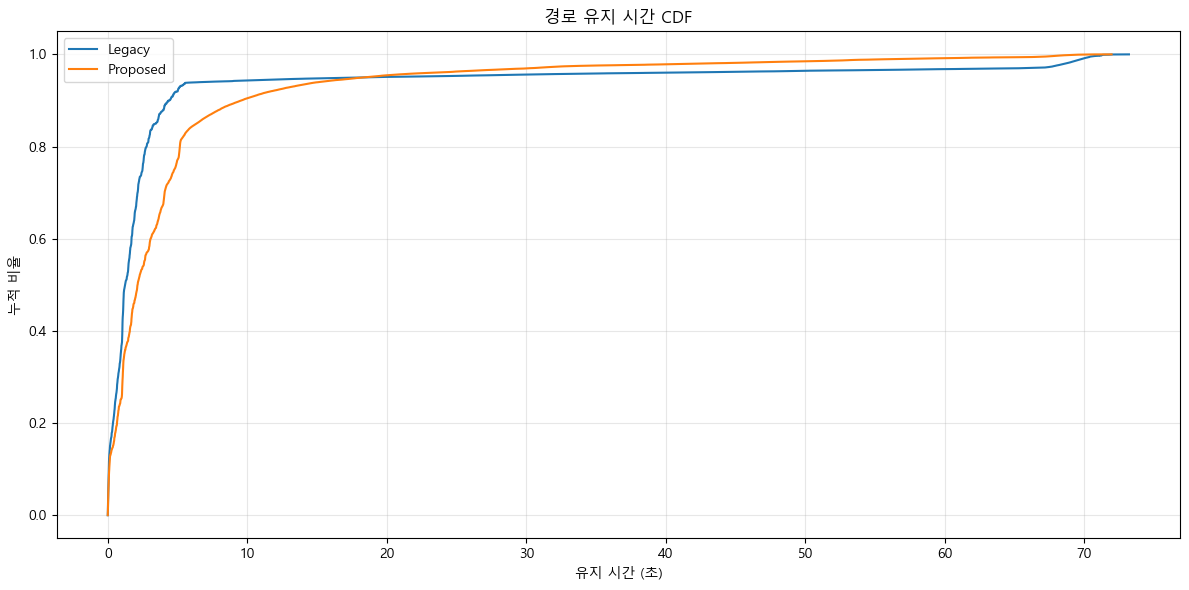

In [18]:
import numpy as np

plt.figure(figsize=(12, 6))

for method in ['Legacy', 'Proposed']:
    data = all_durations[method]
    if not data:
        continue
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    plt.plot(sorted_data, cdf, label=method)

plt.title("경로 유지 시간 CDF")
plt.xlabel("유지 시간 (초)")
plt.ylabel("누적 비율")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()


In [13]:
import os
import pandas as pd
import re

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]
methods = ['L', 'P']
output_dir = os.path.join(base_path, "analysis_results")
os.makedirs(output_dir, exist_ok=True)

manual_columns = [
    'Time', 'Node', 'PacketType', 'Unused1', 'FullPacketType', 'Unused2',
    'DestIP', 'Unused3', 'TxDuration', 'TxType'
]

def load_rerr_times(filepath):
    rerr_times = {}
    if not os.path.exists(filepath):
        return rerr_times
    with open(filepath, 'r') as f:
        current_time = None
        for line in f:
            time_match = re.search(r'\[RERR 생성\] 시간: ([\d.]+)', line)
            if time_match:
                current_time = float(time_match.group(1))
                continue
            dst_match = re.search(r'- 대상: ([\d.]+\.[\d.]+\.[\d.]+\.[\d.]+)', line)
            if dst_match and current_time is not None:
                dst = dst_match.group(1).strip()
                if dst not in rerr_times:
                    rerr_times[dst] = []
                rerr_times[dst].append(current_time)
    return rerr_times

def compute_and_save_durations(df_send_filtered, rerr_times, out_csv_path):
    records = []
    grouped = df_send_filtered.groupby(['Node', 'DestIP'])
    for (node, dst), group in grouped:
        dst = str(dst).strip()
        start_time = group['Time'].min()
        end_time = None
        if dst in rerr_times:
            for rerr_time in sorted(rerr_times[dst]):
                if rerr_time > start_time:
                    end_time = rerr_time
                    break
        if end_time is None:
            end_time = group['Time'].max()
        duration = end_time - start_time
        records.append({
            'Node': node,
            'Destination': dst,
            'StartTime': start_time,
            'EndTime': end_time,
            'Duration': duration
        })
    pd.DataFrame(records).to_csv(out_csv_path, index=False)

for method in methods:
    for node in nodes:
        send_path = os.path.join(base_path, method, density, speed, node, 'aodv_send_log.csv')
        rerr_path = os.path.join(base_path, method, density, speed, node, 'rerr_debug.txt')
        if not os.path.isfile(send_path) or not os.path.isfile(rerr_path):
            continue
        df_send_each = pd.read_csv(send_path, names=manual_columns, header=None)
        df_unicast_each = df_send_each[
            (df_send_each['DestIP'] != '255.255.255.255') &
            (df_send_each['DestIP'].notna())
        ][['Time', 'Node', 'DestIP']]
        df_unicast_each['DestIP'] = df_unicast_each['DestIP'].astype(str).str.strip()
        rerr_times = load_rerr_times(rerr_path)
        out_file = os.path.join(output_dir, f'유지시간_검증_{method}_{node}.csv')
        compute_and_save_durations(df_unicast_each, rerr_times, out_file)


In [14]:
import os
import pandas as pd
import glob

extract_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03/analysis_results"

csv_files = glob.glob(os.path.join(extract_path, "*.csv"))

avg_duration_summary = []

for file in csv_files:
    df = pd.read_csv(file)
    if 'Duration' in df.columns and not df.empty:
        avg_duration = df['Duration'].mean()
        fname = os.path.basename(file)
        method = 'Legacy' if '_L_' in fname else 'Proposed'
        node = fname.split('_')[-1].replace('.csv', '')
        avg_duration_summary.append({
            'Node': node,
            'Method': method,
            'AvgDuration': avg_duration,
            'EntryCount': len(df)
        })

df_avg = pd.DataFrame(avg_duration_summary)
df_avg_pivot = df_avg.pivot(index='Node', columns='Method', values='AvgDuration')
df_avg_pivot['Diff(P - L)'] = df_avg_pivot['Proposed'] - df_avg_pivot['Legacy']
df_avg_pivot.reset_index(inplace=True)
df_avg_pivot.sort_values('Node', inplace=True)

output_csv_path = os.path.join(extract_path, "노드별_평균_경로_유지시간_비교.csv")
df_avg_pivot.to_csv(output_csv_path, index=False)


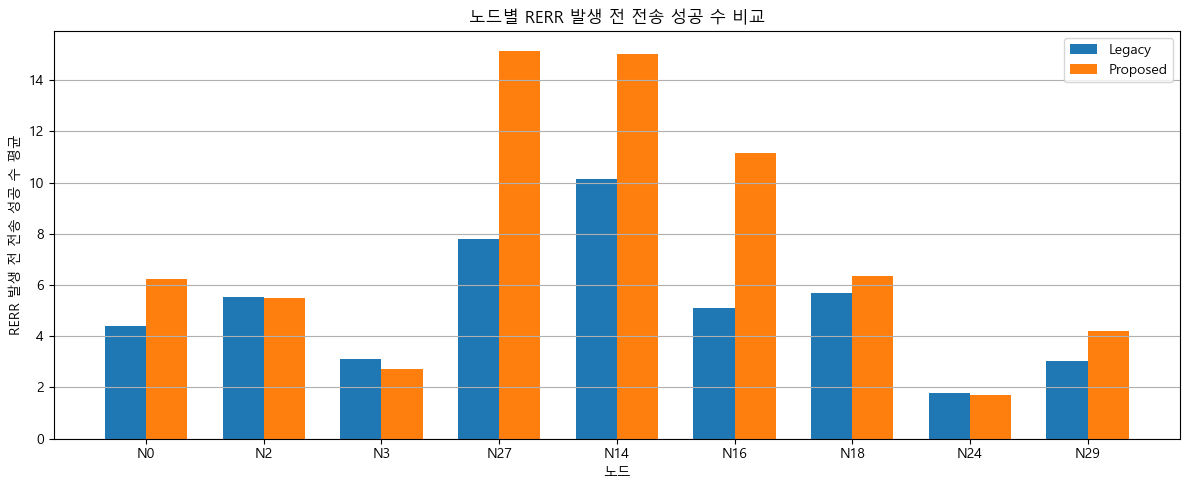

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N27", "N14", "N16", "N18", "N24", "N29"]
time_range = (30.0, 99.0)

def load_success_times(path):
    if not os.path.isfile(path):
        return []
    with open(path, "r") as f:
        times = []
        for line in f:
            if line.strip():
                try:
                    t = float(line.strip().split(":")[0])
                    times.append(t)
                except:
                    continue
        return times

def load_rerr_times(path):
    if not os.path.isfile(path):
        return []
    times = []
    with open(path, "r") as f:
        for line in f:
            try:
                t = float(line.strip().split(":")[1])
                if time_range[0] <= t <= time_range[1]:
                    times.append(t)
            except:
                continue
    return sorted(times)

def count_success_before_each_rerr(success_times, rerr_times):
    count = 0
    rerr_index = 0
    success_index = 0
    rerr_total = len(rerr_times)

    while rerr_index < rerr_total and success_index < len(success_times):
        if success_times[success_index] < rerr_times[rerr_index]:
            count += 1
            success_index += 1
        else:
            rerr_index += 1
    return count, rerr_total

def process_mode(mode):
    result = {}
    for node in nodes:
        success_path = os.path.join(base_path, mode, density, speed, node, "success_app.txt")
        rerr_path = os.path.join(base_path, mode, density, speed, node, "rerr.txt")

        success_times = load_success_times(success_path)
        rerr_times = load_rerr_times(rerr_path)

        count, rerr_total = count_success_before_each_rerr(success_times, rerr_times)
        ratio = count / rerr_total if rerr_total > 0 else 0
        result[node] = ratio
    return result

legacy_result = process_mode("L")
proposed_result = process_mode("P")

x = np.arange(len(nodes))
width = 0.35
legacy_vals = [legacy_result[n] for n in nodes]
proposed_vals = [proposed_result[n] for n in nodes]

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, legacy_vals, width=width, label='Legacy')
plt.bar(x + width/2, proposed_vals, width=width, label='Proposed')
plt.xticks(x, nodes)
plt.xlabel("노드")
plt.ylabel("RERR 발생 전 전송 성공 수 평균")
plt.title("노드별 RERR 발생 전 전송 성공 수 비교")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


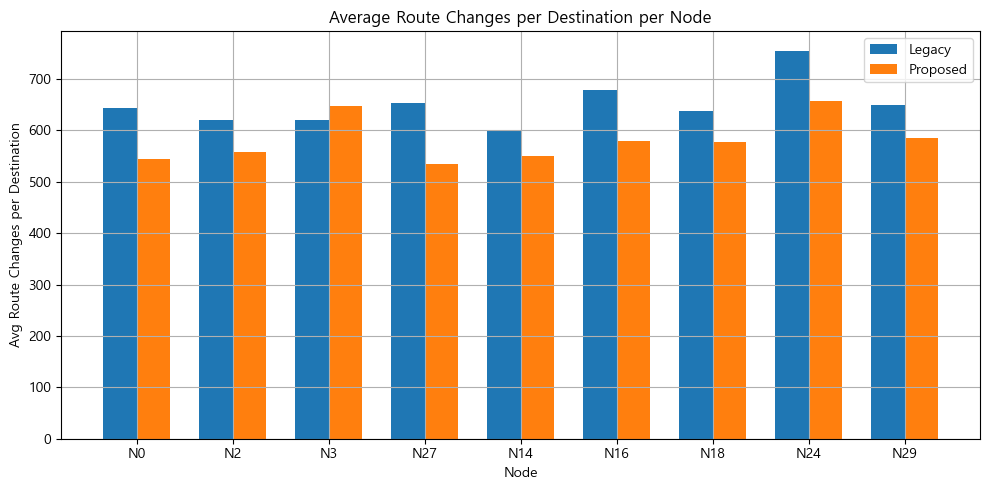

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N27", "N14", "N16", "N18", "N24", "N29"]

def compute_avg_route_changes_per_dest(mode):
    avg_dict = {}
    for node in nodes:
        path = os.path.join(base_path, mode, density, speed, node, "aodv_routing_log.csv")
        if os.path.isfile(path):
            try:
                df = pd.read_csv(path)
                if "Destination" in df.columns:
                    changes_per_dest = df.groupby("Destination").size()
                    avg_dict[node] = changes_per_dest.mean()
                else:
                    avg_dict[node] = 0
            except:
                avg_dict[node] = 0
        else:
            avg_dict[node] = 0
    return avg_dict

legacy_avg = compute_avg_route_changes_per_dest("L")
proposed_avg = compute_avg_route_changes_per_dest("P")

x = range(len(nodes))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar([i - width/2 for i in x], [legacy_avg[n] for n in nodes], width=width, label='Legacy')
plt.bar([i + width/2 for i in x], [proposed_avg[n] for n in nodes], width=width, label='Proposed')

plt.xticks(x, nodes)
plt.xlabel("Node")
plt.ylabel("Avg Route Changes per Destination")
plt.title("Average Route Changes per Destination per Node")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


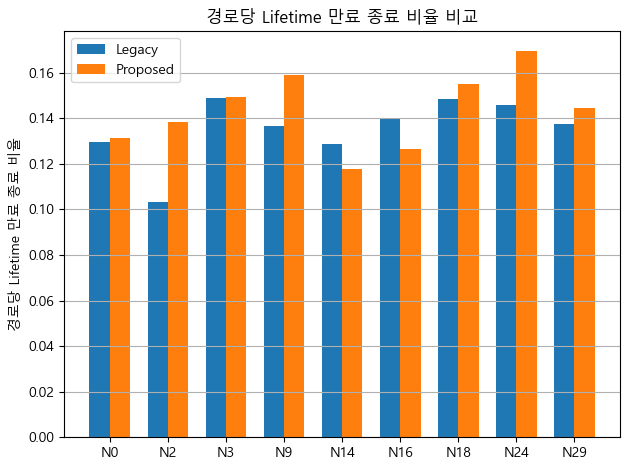

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N9", "N14", "N16", "N18", "N24", "N29"]

def safe_len_csv(path):
    if not os.path.isfile(path):
        return 0
    try:
        return len(pd.read_csv(path))
    except:
        return 0

expired_ratios_legacy = []
expired_ratios_proposed = []

for node in nodes:
    l_base = os.path.join(base_path, "L", density, speed, node)
    p_base = os.path.join(base_path, "P", density, speed, node)

    l_routes = safe_len_csv(os.path.join(l_base, "aodv_routing_log.csv"))
    p_routes = safe_len_csv(os.path.join(p_base, "aodv_routing_log.csv"))

    l_expired = safe_len_csv(os.path.join(l_base, "lifetime_expired_log.csv"))
    p_expired = safe_len_csv(os.path.join(p_base, "lifetime_expired_log.csv"))

    expired_ratios_legacy.append(l_expired / l_routes if l_routes else 0)
    expired_ratios_proposed.append(p_expired / p_routes if p_routes else 0)

x = np.arange(len(nodes))
width = 0.35

plt.figure()
plt.bar(x - width/2, expired_ratios_legacy, width=width, label="Legacy")
plt.bar(x + width/2, expired_ratios_proposed, width=width, label="Proposed")
plt.xticks(x, nodes)
plt.ylabel("경로당 Lifetime 만료 종료 비율")
plt.title("경로당 Lifetime 만료 종료 비율 비교")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
